In [1]:
%load_ext autoreload
%autoreload 2
import gc
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import timer, get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from func.ml_utils import display_importance
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import shutil

try:
    logger
except NameError:
    logger = logger_func()
    
save_file_path = '../output/valid_single_feature.csv'

2019-09-29 15:03:00,731 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']


def make_dataset(is_train):

    if is_train:
        # paths_train = glob('../submit/sub_valid/*_train.gz')
#         paths_train = glob('../feature/raw_use/*_train.gz')
#         paths_train += sorted(glob('../feature/org_use/*_train.gz'))
#         paths_train += sorted(glob('../feature/valid_use/*_train.gz'))
        paths_train = sorted(glob('../submit/re_sub/*_train.gz'))
#         paths_train += glob('../feature/valid_use/533*uid2*_train.gz')
#         paths_train += glob('../feature/valid_use/533*uid3*_train.gz')
#         paths_train += glob('../feature/valid_use/534*_train.gz')
#         paths_train += glob('../feature/valid_use/535*_train.gz')
#         paths_train += glob('../feature/valid_use/536*_train.gz')
#         paths_train += glob('../feature/valid_use/70*_train.gz')
        
        df = parallel_load_data(paths_train)
    
    else:
        # paths_test = glob('../submit/sub_valid/*_test.gz')
#         paths_test = glob('../feature/raw_use/*_test.gz')
#         paths_test += sorted(glob('../feature/org_use/*_test.gz'))
#         paths_test += sorted(glob('../feature/valid_use/*_test.gz'))
        paths_test = sorted(glob('../submit/re_sub/*_test.gz'))
#         paths_test  += glob('../feature/valid_use/533*uid2*_test.gz')
#         paths_test  += glob('../feature/valid_use/533*uid3*_test.gz')
#         paths_test  += glob('../feature/valid_use/534*_test.gz')
#         paths_test += glob('../feature/valid_use/535*_test.gz')
#         paths_test += glob('../feature/valid_use/536*_test.gz')
#         paths_test += glob('../feature/valid_use/70*_test.gz')
        
        df = parallel_load_data(paths_test)
    return df

df_train = make_dataset(True)
df_test = make_dataset(False)

group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
df_train[COLUMN_GROUP] = group

In [9]:
# diff pred & Bear
list_ids = read_pkl_gzip('../output/923_ieee__solo_ids.gz')
# list_ids = read_pkl_gzip('../output/923_ieee__leak_ids.gz')

# Bear
# list_ids = read_pkl_gzip('../output/923_ieee__bear_solo_ids.gz')
# list_ids = read_pkl_gzip('../output/923_ieee__bear_leak_ids.gz')

df_train_part = df_train[df_train[COLUMN_ID].isin(list_ids)]
print(df_train_part.shape)
print(df_train_part[COLUMN_TARGET].value_counts())
display(df_train_part['DT-M'].value_counts())

#========================================================================
# Cut 2017-12
#========================================================================
# df_train_part = df_train_part[df_train_part[COLUMN_GROUP]!='2017-12']

#========================================================================
# Negative Down Sampling
#========================================================================
# frac = 0.2
# frac = 1.0
# seed = 1208
# np.random.seed(seed)
# df_pos = df_train_part[df_train_part.isFraud==1]
# df_neg = df_train_part[df_train_part.isFraud!=1]
# del df_train_part
# gc.collect()
# print(df_pos.shape, df_neg.shape)
# df_neg = df_neg.sample(int(df_neg.shape[0] * frac))
# df_train_2 = pd.concat([df_pos, df_neg], axis=0)
# print(df_train_2.shape)
df_train_2 = df_train_part


#========================================================================
# bear
#========================================================================
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 3, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,3]]
bear.columns = [COLUMN_ID, 'data_type', COLUMN_TARGET]
submission = pd.read_csv('../input/sample_submission.csv')
submission.columns = [COLUMN_ID, 'pred']

    
def valid_submit_prediction(prediction):
    """Summary line.
    他Submit Prediction Valueとの相関をチェック
    Args:
    
    Returns:
    """
    list_submit_path = sorted(glob('../submit/validation/*.csv'))
    list_submit = []
    
    print("* Check Corr with Past Submit.")
    for path in list_submit_path:
        lb_score = re.search(rf'([^/LB]*).csv', path).group(1)
        submit = pd.read_csv(path)[COLUMN_TARGET].values
        
        print('  * ', prediction.shape, submit.shape)
        corr = np.min(np.corrcoef(prediction, submit))
        print(f"  * LB{lb_score} / {corr}")

        
def bear_validation(test_pred):
    submission['pred'] = test_pred
    bear_score = submission.merge(bear, how='inner', on=COLUMN_ID)
    public  = bear_score[bear_score['data_type']=='test_public']
    private = bear_score[bear_score['data_type']=='test_private']
    
    public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
    private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
    all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)

    return public_score, private_score, all_score

(498108, 1809)
0    483714
1     14394
Name: isFraud, dtype: int64


2017-12    117399
2018-3      88992
2018-5      78897
2018-1      75406
2018-4      68929
2018-2      68485
Name: DT-M, dtype: int64

In [ ]:
sub["isFraud"] = pred_1["isFraud"] * x_opt[0] + pred_2["isFraud"] * x_opt[1] + pred_3["isFraud"] * x_opt[2] + pred_4["isFraud"] * x_opt[3]
pub, prv = calc_bear_score(sub)
logger.info(f"ensemble model: pub{pub}, prv{prv}")
sub.to_csv("sub_avg.csv",header=True,index=False)
import pdb; pdb.set_trace()

# override probing value and save
df_probing = pd.read_csv('data/interim/probing_toolbox/probing.csv').loc[:, ['TransactionID', 'data_type', 'Probing_isFraud']]
sub = pd.merge(sub, df_probing, on="TransactionID", how="left")
sub.loc[sub.Probing_isFraud.notnull(), "isFraud"] = sub.loc[sub.Probing_isFraud.notnull(), "Probing_isFraud"].values
sub = sub[["TransactionID", "isFraud"]]
pub, prv = calc_bear_score(sub)
logger.info(f"ensemble model after override proving value: pub{pub}, prv{prv}")
sub.to_csv("sub_avg.csv",header=True,index=False)

In [ ]:
list_oof = []

#========================================================================
# Base Featureに検証用Feature Groupを追加して、スコアの変化を見る.
# Baseより向上したFeature Groupのみ、追加検証を行う
#========================================================================
np.random.seed(1)

# 最初はbaseをTrueにして
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:14]
is_base = [True, False][0]
is_result = [True, False][0]
is_write  = [True, False][1]
to_dir = '../feature/check_trush/'
list_feim = []

def get_tree_importance(estimator, use_cols, importance_type="gain"):
    feim = estimator.feature_importance(importance_type=importance_type)
    feim = pd.DataFrame([np.array(use_cols), feim]).T
    feim.columns = ['feature', 'importance']
    feim['importance'] = feim['importance'].astype('float32')
    return feim


# valid_paths_train = sorted(glob('../feature/valid/*_train.gz'))
# valid_paths_train = sorted(glob('../feature/valid_use/*_train.gz'))
valid_paths_train = []
loop_no = len(valid_paths_train)
if len(valid_paths_train)==0 and (is_base or is_result):
    loop_no = 1
    
score_map = {}
    
for i in range(loop_no):
    
    if is_result:
        valid_path = valid_paths_train
    else:
        valid_path = valid_paths_train[i:i+1]
        
    
    if is_base or len(valid_path)==0:
        tmp_train = df_train_2.copy()
        feature_name = 'base'
    else:
        df_feat_train = parallel_load_data(valid_path)
        tmp_train = df_train_2.join(df_feat_train)
        feature_name = get_filename(valid_path[0])
    
    use_cols = [col for col in tmp_train.columns if col not in COLUMNS_IGNORE]
    
    fold_map = {
        0: '2018-5',
        1: '2018-4',
#         2: '2018-3',
        2: '2017-12',
    }
    
    logger.info(f'Train Shape: {tmp_train[use_cols].shape}' , )
    
    x_test = df_test[use_cols]
        
    for fold in range(3):
        with timer('  * Make Dataset'):
            if fold==0:
                train = tmp_train[
                    (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') | 
                    (tmp_train[COLUMN_GROUP] == '2018-4')
                    ]
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-5']
            elif fold==1:
                train = tmp_train[
                    (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') |
#                     (tmp_train[COLUMN_GROUP] == '2018-4') |
                    (tmp_train[COLUMN_GROUP] == '2018-5')
                    ]
#                 test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-5']
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-4']
            elif fold==2:
                train = tmp_train[
#                     (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') |
                    (tmp_train[COLUMN_GROUP] == '2018-4') |
                    (tmp_train[COLUMN_GROUP] == '2018-5')
                    ]
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2017-12']
        
            Y_TRAIN = train[COLUMN_TARGET]
            train.drop(COLUMN_TARGET, axis=1, inplace=True)
        
            Y_TEST = test[COLUMN_TARGET]
            test.drop(COLUMN_TARGET, axis=1, inplace=True)
        
        start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:13]
        params = {
            'n_jobs': 96,
#             'n_jobs': 40,
#             'n_jobs': 30,
#             'n_jobs': 16,
            'metric': 'auc',
            'objective': 'binary',
            'num_leaves': 2**7-1,
#             'num_leaves': 2**8-1,
            'max_depth': -1,
            'subsample': 0.9,
            'subsample_freq': 1,
            'colsample_bytree' : 0.10,
            'lambda_l1' : 0.1,
            'lambda_l2' : 1.0,
            'learning_rate' : 0.1,
            'learning_rate' : 0.05,
            "seed": 1208,
            "bagging_seed": 1208,
            "feature_fraction_seed": 1208,
            "drop_seed": 1208,
        }

        x_train = train[use_cols]
        y_train = Y_TRAIN
        x_valid = test[use_cols]
        y_valid = Y_TEST
        early_stopping_rounds=20
        early_stopping_rounds=50
#         early_stopping_rounds=500
        num_boost_round=1500
        metric = 'auc'
        params['metric'] = metric
        
        #========================================================================
        # Fitting
        #========================================================================
        lgb_train = lgb.Dataset(data=x_train, label=y_train)
        lgb_valid = lgb.Dataset(data=x_valid, label=y_valid)
        
        with timer("  * Train & Validation"):
            estimator = lgb.train(
                params = params,
                train_set = lgb_train,
                valid_sets = lgb_valid,
                early_stopping_rounds = early_stopping_rounds,
                num_boost_round = num_boost_round,
                verbose_eval = 200
            )
            best_iter = estimator.best_iteration
        
            oof_pred = estimator.predict(x_valid)
            list_oof.append(oof_pred)
            score = roc_auc_score(y_valid, oof_pred)
            cvs = str(score).replace('.', '-')
            logger.info(f"  * {feature_name} Fold{fold} {fold_map[fold]}:{score}")
            
            score_map[fold_map[fold]] = score
            
            feim = get_tree_importance(estimator=estimator, use_cols=x_train.columns)
            feim.sort_values(by='importance', ascending=False, inplace=True)
            feim.set_index('feature', inplace=True)
            list_feim.append(feim)
            
            #========================================================================
            # Public Private Validation
            #========================================================================
            test_pred = estimator.predict(x_test)
#             valid_submit_prediction(test_pred)
            pb, pv, al = bear_validation(test_pred)
            logger.info(f'  * PB: {pb} PV: {pv} ALL: {al}')
            
            if not is_result and is_write:
                with open(save_file_path, 'a') as f:
                    line = f'{start_time},{fold_map[fold]},{feature_name},{score}\n'
                    f.write(line)
                    
    logger.info(pd.Series(score_map))
    
    df_feim = pd.concat(list_feim, axis=1).reset_index().rename(columns={'index': 'feature'}).set_index('feature')
    
    df_feim['imp_avg'] = df_feim.mean(axis=1)
    df_feim.sort_values(by='imp_avg', ascending=False, inplace=True)
    display_importance(df_feim)

2019-09-29 15:23:33,510 func.utils 59 [INFO]    [<module>] Train Shape: (498108, 1805) 


[  * Make Dataset] done in 6 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.942092
Early stopping, best iteration is:
[218]	valid_0's auc: 0.942382


2019-09-29 15:25:18,949 func.utils 158 [INFO]    [<module>]   * base Fold0 2018-5:0.942382493901414 
2019-09-29 15:25:53,644 func.utils 173 [INFO]    [<module>]   * PB: 0.7105457862102791 PV: 0.6290210820653337 ALL: 0.6620445169671643 


[  * Train & Validation] done in 129 s
[  * Make Dataset] done in 9 s


In [ ]:
# diff pred & Bear
# list_ids = read_pkl_gzip('../output/923_ieee__solo_ids.gz')
list_ids = read_pkl_gzip('../output/923_ieee__leak_ids.gz')

# Bear
# list_ids = read_pkl_gzip('../output/923_ieee__bear_solo_ids.gz')
# list_ids = read_pkl_gzip('../output/923_ieee__bear_leak_ids.gz')

df_train_part = df_train[df_train[COLUMN_ID].isin(list_ids)]
print(df_train_part.shape)
print(df_train_part[COLUMN_TARGET].value_counts())
display(df_train_part['DT-M'].value_counts())


#========================================================================
# Negative Down Sampling
#========================================================================
# frac = 0.2
# frac = 1.0
# seed = 1208
# np.random.seed(seed)
# df_pos = df_train_part[df_train_part.isFraud==1]
# df_neg = df_train_part[df_train_part.isFraud!=1]
# del df_train_part
# gc.collect()
# print(df_pos.shape, df_neg.shape)
# df_neg = df_neg.sample(int(df_neg.shape[0] * frac))
# df_train_2 = pd.concat([df_pos, df_neg], axis=0)
# print(df_train_2.shape)
df_train_2 = df_train_part

In [ ]:
list_oof_2 = []

#========================================================================
# Base Featureに検証用Feature Groupを追加して、スコアの変化を見る.
# Baseより向上したFeature Groupのみ、追加検証を行う
#========================================================================
np.random.seed(1)

# 最初はbaseをTrueにして
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:14]
is_base = [True, False][0]
is_result = [True, False][0]
is_write  = [True, False][1]
to_dir = '../feature/check_trush/'
list_feim = []

def get_tree_importance(estimator, use_cols, importance_type="gain"):
    feim = estimator.feature_importance(importance_type=importance_type)
    feim = pd.DataFrame([np.array(use_cols), feim]).T
    feim.columns = ['feature', 'importance']
    feim['importance'] = feim['importance'].astype('float32')
    return feim


# valid_paths_train = sorted(glob('../feature/valid/*_train.gz'))
# valid_paths_train = sorted(glob('../feature/valid_use/*_train.gz'))
valid_paths_train = []
loop_no = len(valid_paths_train)
if len(valid_paths_train)==0 and (is_base or is_result):
    loop_no = 1
    
score_map = {}
    
for i in range(loop_no):
    
    if is_result:
        valid_path = valid_paths_train
    else:
        valid_path = valid_paths_train[i:i+1]
        
    
    if is_base or len(valid_path)==0:
        tmp_train = df_train_2.copy()
        feature_name = 'base'
    else:
        df_feat_train = parallel_load_data(valid_path)
        tmp_train = df_train_2.join(df_feat_train)
        feature_name = get_filename(valid_path[0])
    
    use_cols = [col for col in tmp_train.columns if col not in COLUMNS_IGNORE]
    
    fold_map = {
        0: '2018-5',
        1: '2018-4',
#         2: '2018-3',
        2: '2017-12',
    }
    
    logger.info(f'Train Shape: {tmp_train[use_cols].shape}' , )
    
    x_test = df_test[use_cols]
        
    for fold in range(3):
        with timer('  * Make Dataset'):
            if fold==0:
                train = tmp_train[
                    (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') | 
                    (tmp_train[COLUMN_GROUP] == '2018-4')
                    ]
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-5']
            elif fold==1:
                train = tmp_train[
                    (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') |
#                     (tmp_train[COLUMN_GROUP] == '2018-4') |
                    (tmp_train[COLUMN_GROUP] == '2018-5')
                    ]
#                 test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-5']
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2018-4']
            elif fold==2:
                train = tmp_train[
#                     (tmp_train[COLUMN_GROUP] == '2017-12') | 
                    (tmp_train[COLUMN_GROUP] == '2018-1') | 
                    (tmp_train[COLUMN_GROUP] == '2018-2') | 
                    (tmp_train[COLUMN_GROUP] == '2018-3') |
                    (tmp_train[COLUMN_GROUP] == '2018-4') |
                    (tmp_train[COLUMN_GROUP] == '2018-5')
                    ]
                test  = tmp_train[tmp_train[COLUMN_GROUP] == '2017-12']
        
            Y_TRAIN = train[COLUMN_TARGET]
            train.drop(COLUMN_TARGET, axis=1, inplace=True)
        
            Y_TEST = test[COLUMN_TARGET]
            test.drop(COLUMN_TARGET, axis=1, inplace=True)
        
        start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())[:13]
        params = {
            'n_jobs': 96,
#             'n_jobs': 40,
#             'n_jobs': 30,
#             'n_jobs': 16,
            'metric': 'auc',
            'objective': 'binary',
            'num_leaves': 2**7-1,
#             'num_leaves': 2**8-1,
            'max_depth': -1,
            'subsample': 0.9,
            'subsample_freq': 1,
            'colsample_bytree' : 0.10,
            'lambda_l1' : 0.1,
            'lambda_l2' : 1.0,
            'learning_rate' : 0.1,
            'learning_rate' : 0.05,
            "seed": 1208,
            "bagging_seed": 1208,
            "feature_fraction_seed": 1208,
            "drop_seed": 1208,
        }

        x_train = train[use_cols]
        y_train = Y_TRAIN
        x_valid = test[use_cols]
        y_valid = Y_TEST
        early_stopping_rounds=20
        early_stopping_rounds=50
#         early_stopping_rounds=500
        num_boost_round=1500
        metric = 'auc'
        params['metric'] = metric
        
        #========================================================================
        # Fitting
        #========================================================================
        lgb_train = lgb.Dataset(data=x_train, label=y_train)
        lgb_valid = lgb.Dataset(data=x_valid, label=y_valid)
        
        with timer("  * Train & Validation"):
            estimator = lgb.train(
                params = params,
                train_set = lgb_train,
                valid_sets = lgb_valid,
                early_stopping_rounds = early_stopping_rounds,
                num_boost_round = num_boost_round,
                verbose_eval = 200
            )
            best_iter = estimator.best_iteration
        
            oof_pred = estimator.predict(x_valid)
            list_oof_2.append(oof_pred)
            score = roc_auc_score(y_valid, oof_pred)
            cvs = str(score).replace('.', '-')
            logger.info(f"  * {feature_name} Fold{fold} {fold_map[fold]}:{score}")
            
            score_map[fold_map[fold]] = score
            
            feim = get_tree_importance(estimator=estimator, use_cols=x_train.columns)
            feim.sort_values(by='importance', ascending=False, inplace=True)
            feim.set_index('feature', inplace=True)
            list_feim.append(feim)
            
            #========================================================================
            # Public Private Validation
            #========================================================================
            test_pred = estimator.predict(x_test)
#             valid_submit_prediction(test_pred)
            pb, pv, al = bear_validation(test_pred)
            logger.info(f'  * PB: {pb} PV: {pv} ALL: {al}')
            
            if not is_result and is_write:
                with open(save_file_path, 'a') as f:
                    line = f'{start_time},{fold_map[fold]},{feature_name},{score}\n'
                    f.write(line)
                    
    logger.info(pd.Series(score_map))
    
    df_feim = pd.concat(list_feim, axis=1).reset_index().rename(columns={'index': 'feature'}).set_index('feature')
    
    df_feim['imp_avg'] = df_feim.mean(axis=1)
    df_feim.sort_values(by='imp_avg', ascending=False, inplace=True)
    display_importance(df_feim)

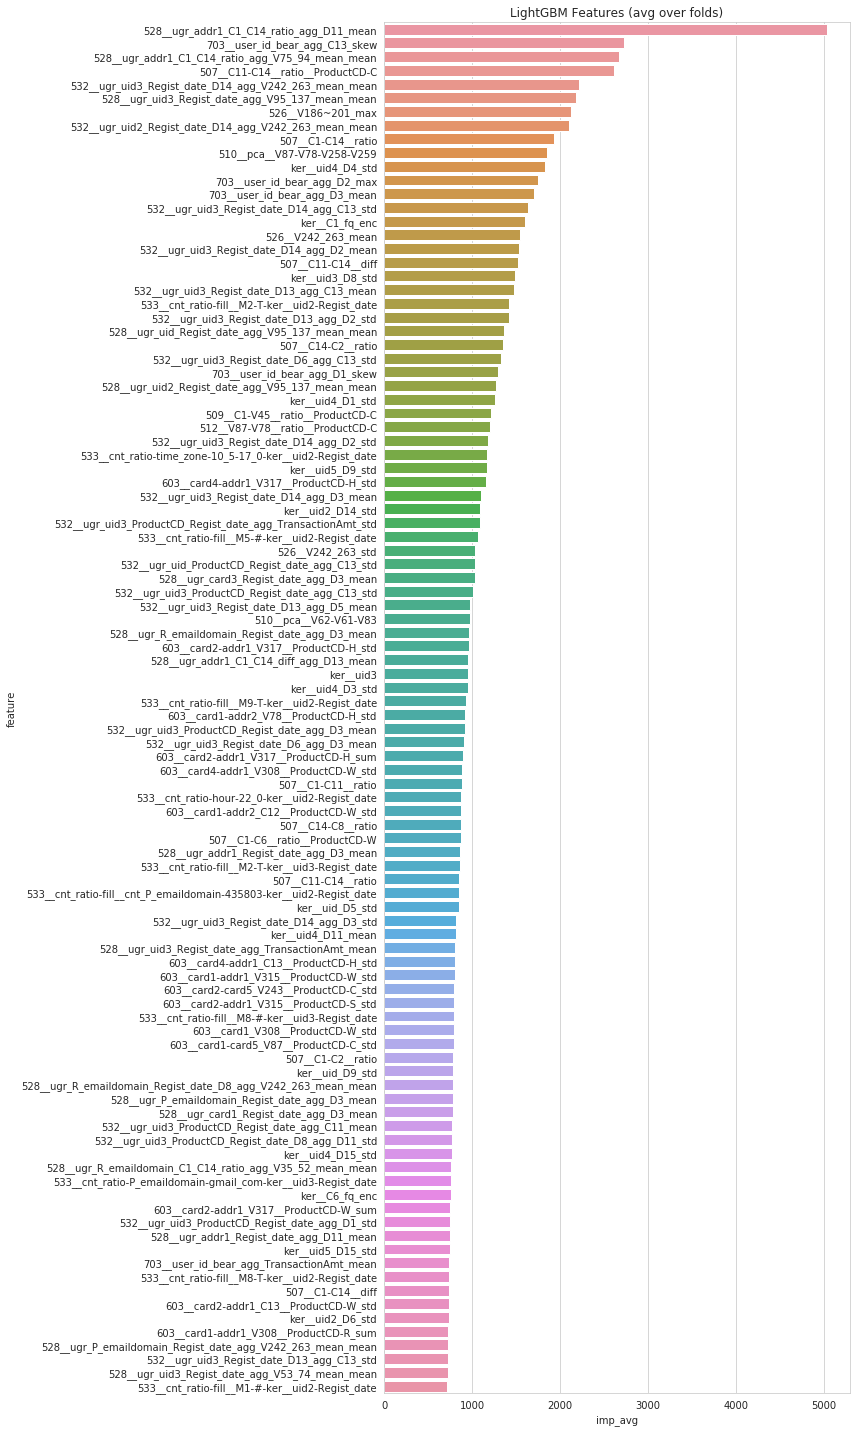

In [13]:
display_importance(df_feim)

In [10]:
key1 = '70'
key2 = '533'
idx = [col for col in df_feim.index if
       col.count(key1)
#        and
       or
       col.count(key2)
      ]
feim = df_feim.loc[idx]
# feim = df_feim
feim.tail(500)

,importance,importance,importance,imp_avg
feature,,,,
533__cnt_ratio-hour-21_0-ker__uid3-Regist_date,50.330883,96.952309,27.165167,58.149448
533__cnt_ratio-ProductCD-H-ker__uid2-Regist_date,55.328140,64.286743,54.074787,57.896557
533__cnt_ratio-501__cnt__id_29-128492_0-ker__uid3-Regist_date,17.095638,124.652809,31.409214,57.719219
701__ugr_user_id_bear_D14_agg_C12_std,125.966728,8.657034,38.449600,57.691120
701__ugr_user_id_bear_D14_agg_C2_skew,46.684414,93.698288,31.953314,57.445339
701__ugr_user_id_bear_C1_C14_ratio_agg_D3_max,21.357229,45.603676,104.753426,57.238110
533__cnt_ratio-hour-6_5-ker__uid2-Regist_date,23.871380,63.927856,83.082359,56.960529
533__cnt_ratio-fill__R_emaildomain_suffix-#-ker__uid2-Regist_date,31.636959,78.767113,60.382603,56.928890
701__ugr_user_id_bear_D8_agg_D2_mean,43.851093,108.126686,18.490679,56.822819


In [11]:
cnt = 0
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
# for feature_name in feim[feim['imp_avg']<1000].index:
for feature_name in feim[feim['imp_avg']<50].index:
    
#     if not feature_name.count('533_'):
#     if feature_name.count('533_') or feature_name.count('534_'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
#     from_dir = '../submit/re_sub'
#     from_dir = '../submit/add_feature/'
#     from_dir = 'org_use'
    from_dir = 'valid_use'
#     to_dir = '../submit/add_feature'
    to_dir = 'valid_trush'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
#         print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
        cnt+=1
    except FileNotFoundError:
        print(feature_name)
print(cnt)

445
